# What Algorithm to choose?
![alt text](./img/cheat_sheet.png)

![alt text](./img/nuclear.jpg)

# XGBoost. The very best there is. When you absolutely, positively got to forecast everything in the room, accept no substitutes.

# The XGBoost Advantage

### Regularization:
Standard GBM implementation has no regularization like XGBoost, therefore it also helps to reduce overfitting.
In fact, XGBoost is also known as ‘regularized boosting‘ technique.
### Parallel Processing:
XGBoost implements parallel processing and is blazingly faster as compared to GBM.
But hang on, we know that boosting is sequential process so how can it be parallelized? We know that each tree can be built only after the previous one, so what stops us from making a tree using all cores? I hope you get where I’m coming from. Check this link out to explore further.
XGBoost also supports implementation on Hadoop.
### High Flexibility
XGBoost allow users to define custom optimization objectives and evaluation criteria.
This adds a whole new dimension to the model and there is no limit to what we can do.
### Handling Missing Values
XGBoost has an in-built routine to handle missing values.
User is required to supply a different value than other observations and pass that as a parameter. XGBoost tries different things as it encounters a missing value on each node and learns which path to take for missing values in future.
### Tree Pruning:
A GBM would stop splitting a node when it encounters a negative loss in the split. Thus it is more of a greedy algorithm.
XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain.
Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10. GBM would stop as it encounters -2. But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.
### Built-in Cross-Validation
XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.
This is unlike GBM where we have to run a grid-search and only a limited values can be tested.
Continue on Existing Model
User can start training an XGBoost model from its last iteration of previous run. This can be of significant advantage in certain specific applications.
GBM implementation of sklearn also has this feature so they are even on this point.

###### Courtesy of AARSHAY JAIN 
###### https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [48]:
from numpy import loadtxt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np


# read data in
df = pd.read_csv('ml_ready_data.csv', index_col='Unnamed: 0', low_memory=False)
# CSVs are dumb, sometimes need to force things to numeric
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Building your first Model

In [49]:
# select X & Y
y = 'SalesClosePrice'
feature_names = list(df.columns.values)
feature_names.remove(y)

![alt text](./img/dependent-vs-independent-variable1.jpg)

In [50]:
# split data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(df[feature_names], df[y], test_size=0.5, random_state=42)

![alt text](./img/train-test.png)

In [51]:
# keep labels on test/train
X_train = pd.DataFrame(data=Xtrain, columns=feature_names)
Xtest = pd.DataFrame(data=Xtest, columns=feature_names)

dtrain = xgb.DMatrix(Xtrain, label=ytrain)

In [52]:
# fit model no training data
model = xgb.XGBRegressor(n_jobs=4)
model.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Evaluating your model, what Metrics to use?

* metrics.explained_variance_score(y_true, y_pred)	
    * Explained variance regression score function


* metrics.mean_absolute_error(y_true, y_pred)	       
    * Mean absolute error regression loss

* metrics.mean_squared_error(y_true, y_pred[, …])	    
    * Mean squared error regression loss


* metrics.mean_squared_log_error(y_true, y_pred)	    
    * Mean squared logarithmic error regression loss


* metrics.median_absolute_error(y_true, y_pred)	    
    * Median absolute error regression loss


* metrics.r2_score(y_true, y_pred[, …])	            
    * R^2 (coefficient of determination) regression score function.

In [53]:
# make predictions for test data
ypred = model.predict(Xtest)
predictions = [round(value) for value in ypred]

In [73]:
from math import sqrt
rmse = sqrt(mean_squared_error(ytest, ypred))
rmse

14835.517311933028

In [74]:
# evaluate predictions
r2_score(ytest, ypred)

0.9898614614072536

# Difference between R^2 and RMSE?

Both indicate the goodness of the fit.

R-squared is conveniently scaled between 0 and 1, whereas RMSE is not scaled to any particular values. This can be good or bad; obviously R-squared can be more easily interpreted, but with RMSE we explicitly know how much our predictions deviate, on average, from the actual values in the dataset. So in a way, RMSE tells you more.

###### user3796494
###### https://stats.stackexchange.com/questions/142248/difference-between-r-square-and-rmse-in-linear-regression

# Tuning Your Model

In [71]:
# Set the parameters by cross-validation
tuned_parameters = [{'subsample': [1], 'colsample_bytree': [1], 'gamma':[0], 
                     'learning_rate':[0.1,], 'max_depth': [4, 5, 6], 
                     'min_child_weight': [0.1, 0.5, 0.75]}]


print("# Tuning hyper-parameters for r2")
print()

model = GridSearchCV(xgb.XGBRegressor(n_jobs=4), tuned_parameters, cv=5, scoring='r2')
model.fit(Xtrain, ytrain)

print("Best parameters set found on development set:")
print()
print(model.best_params_)
print()
print("Grid scores on development set:")
print()
means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

# Tuning hyper-parameters for r2

Best parameters set found on development set:

{'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 0.1, 'subsample': 1}

Grid scores on development set:

0.954 (+/-0.099) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.1, 'subsample': 1}
0.954 (+/-0.099) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.5, 'subsample': 1}
0.954 (+/-0.099) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 0.75, 'subsample': 1}
0.954 (+/-0.106) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.1, 'subsample': 1}
0.954 (+/-0.106) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 0.5, 'subsample': 1}
0.954 (+/-0.106) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth

### Now we can explore the 'best' model we have

In [68]:
# fit model no training data
model = xgb.XGBRegressor(max_depth=5, min_child_weight=0.1, n_jobs=4)
model.fit(Xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=0.1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
# make predictions for test data
ypred = model.predict(Xtest)
predictions = [round(value) for value in ypred]

In [70]:
rmse = sqrt(mean_squared_error(ytest, ypred))
rmse

14835.517311933028

# What is important?

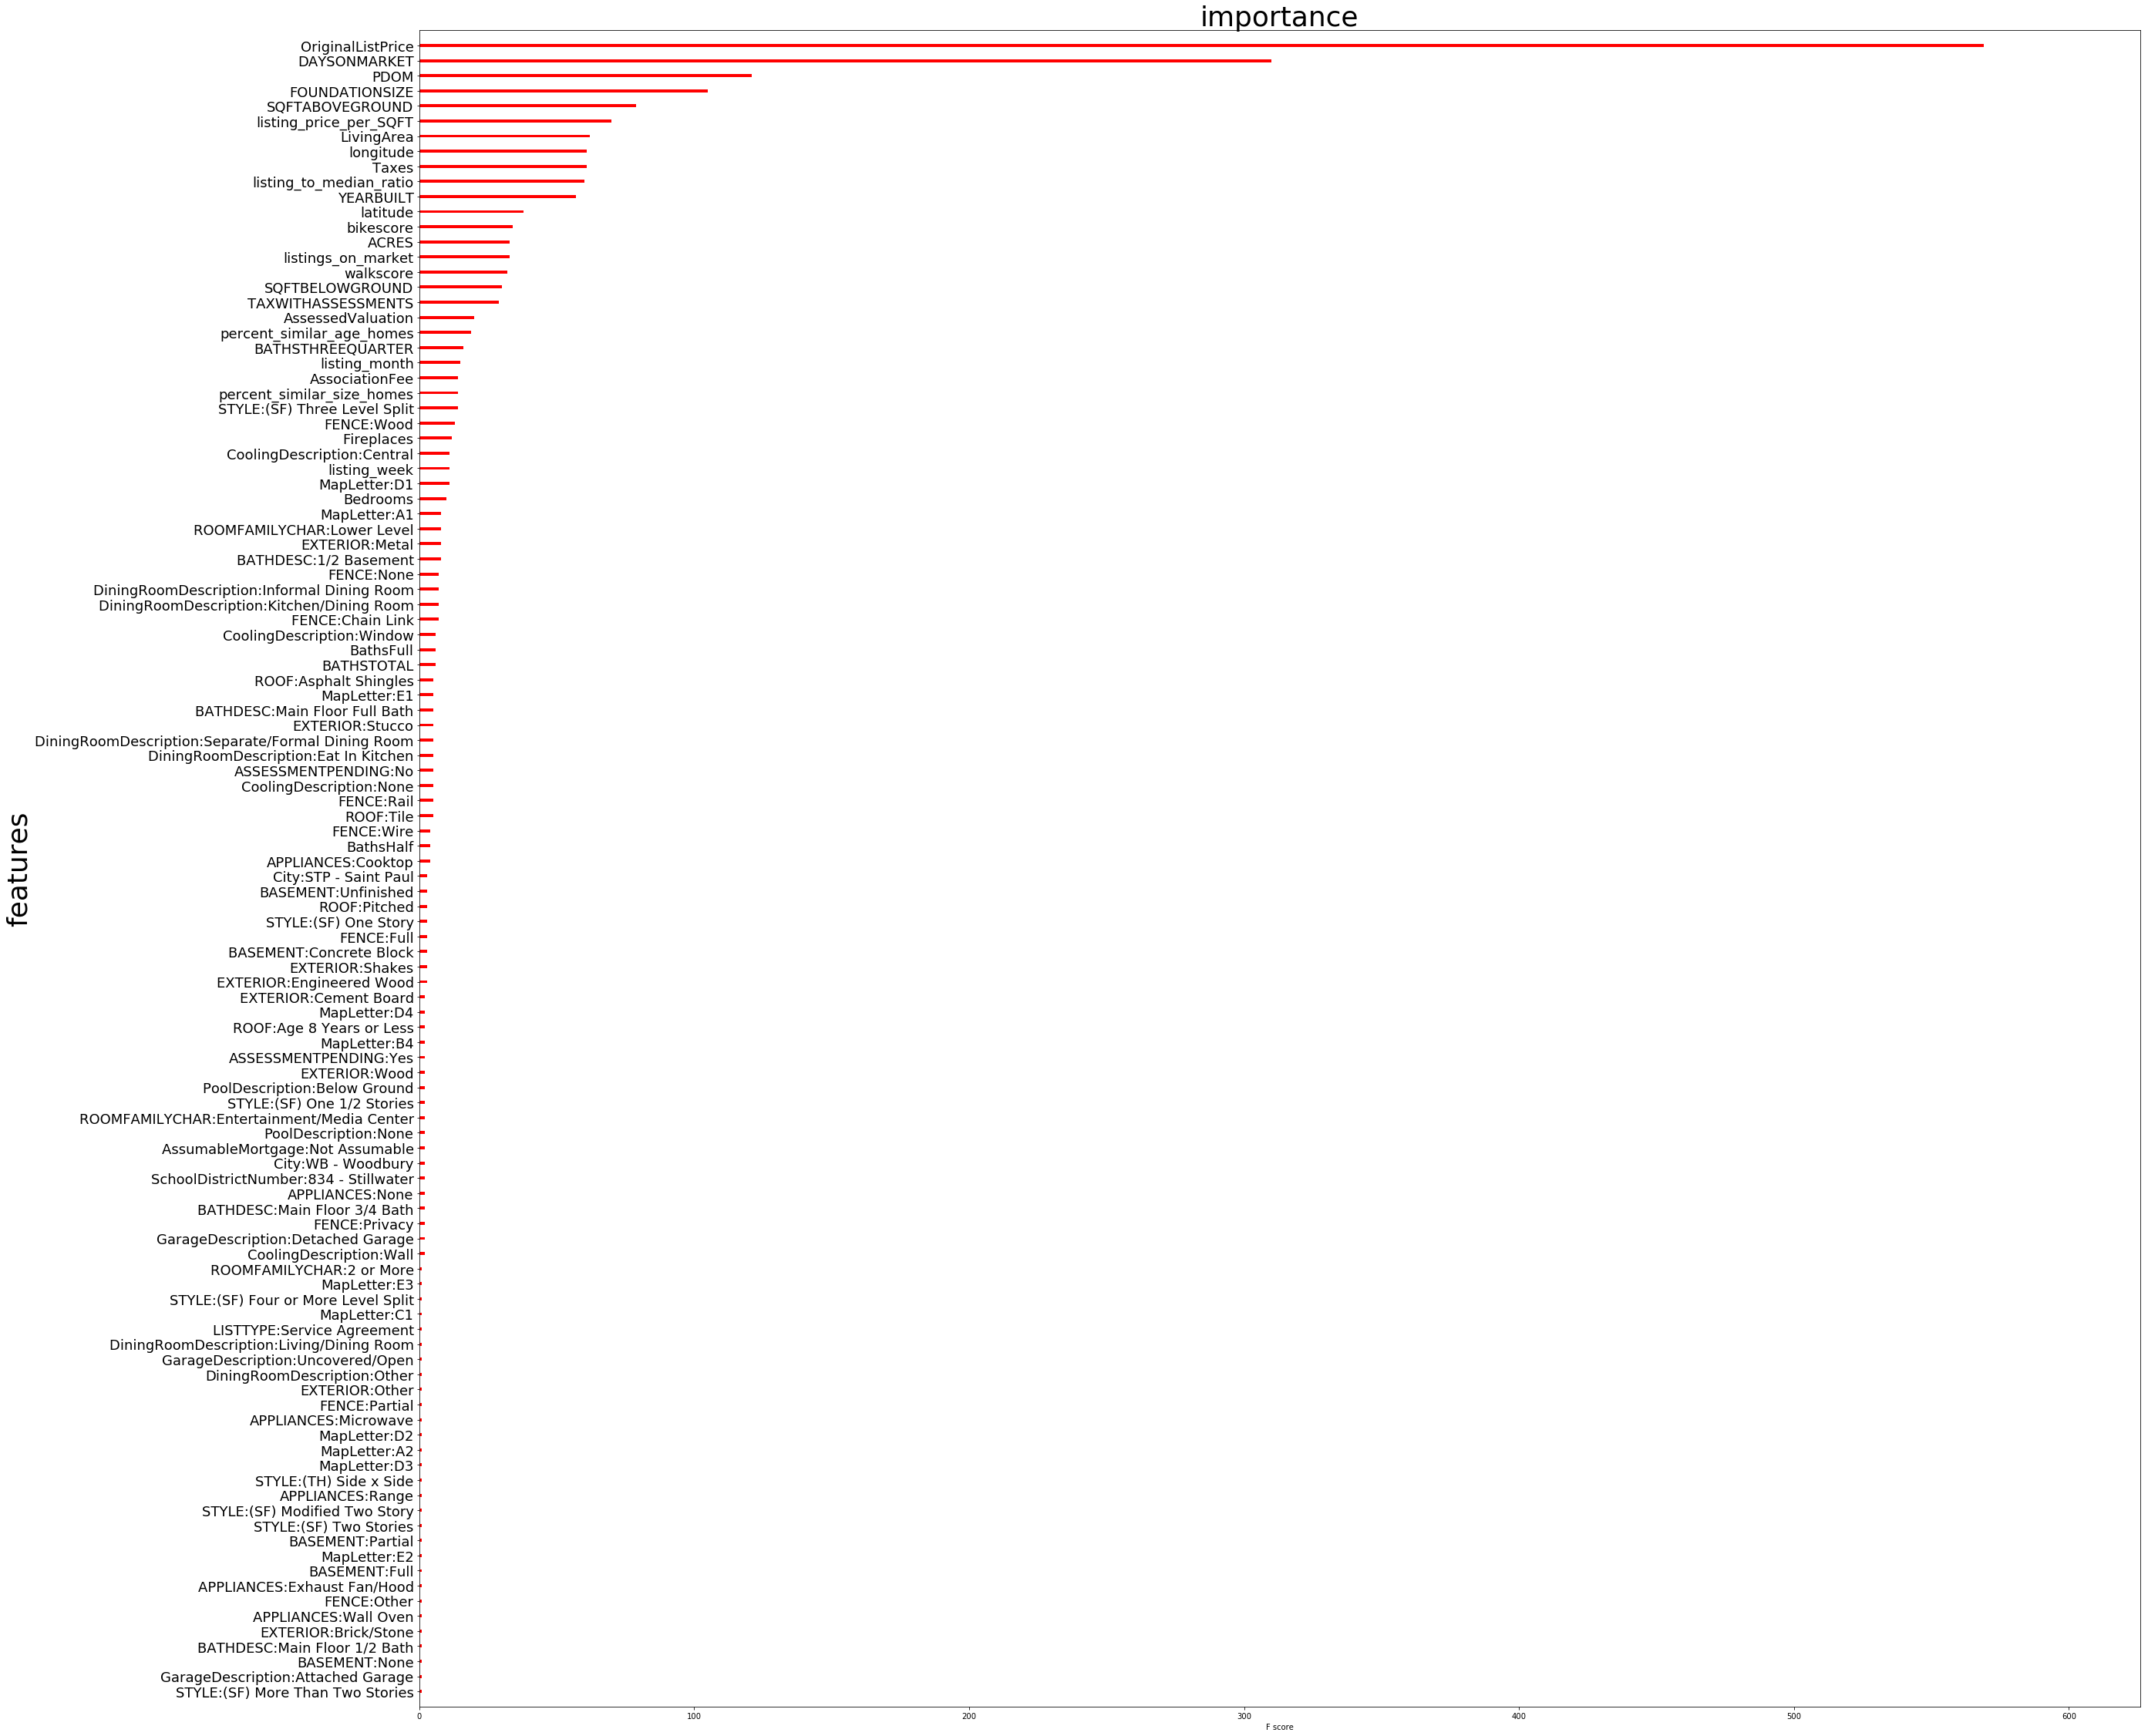

In [60]:
from xgboost import plot_importance
%matplotlib inline
from matplotlib import pyplot as plt

# feature importance
fig, ax = plt.subplots(figsize=(40, 40))
plot_importance(model, color='red', grid=False, show_values=False, ax=ax)
plt.title('importance', fontsize = 36)
plt.yticks(fontsize = 18)
plt.ylabel('features', fontsize = 36)

# What can we afford to lose?

* Too many variables can slow run time of model
* Can hamper explainability
* May be hard to curate
* May not be reported in a timely manner

In [ ]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# fit model on all training data
model = xgb.XGBClassifier()
model.fit(Xtrain, ytrain)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
r2 = r2_score(ytest, predictions)
print("r2: %.2f%%" % (r2))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(Xtrain)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, ytrain)
    # eval model
    select_X_test = selection.transform(Xtest)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    r2 = r2_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, r2: %.2f%%" % (thresh, select_X_train.shape[1], r2))

# What if we want to answer a different question?

In [ ]:
# del df['listing_to_median_ratio']
# del df['listing_price_per_SQFT']
# del df['OriginalListPrice']
# prep X & Y
y = 'SalesClosePrice'
feature_names = list(df.columns.values)
feature_names.remove(y)
# split data into train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(df[feature_names], df[y], test_size=0.5)
# fit model no training data
model = xgb.XGBRegressor(max_depth=5, min_child_weight=0.1, n_jobs=4)
model.fit(Xtrain, ytrain)
# make predictions for test data
ypred = model.predict(Xtest)
predictions = [round(value) for value in ypred]
mse = mean_squared_error(ytest, ypred)
rmse = sqrt(mse)
rmse